In [6]:
from fastai.vision.all import *
import fastai
import timm
from wwf.vision.timm import *
import pandas as pd

In [7]:
import torch
torch.cuda.set_device(3)

In [8]:
df = pd.read_csv('data/wheat_new.csv',decimal=',')

In [9]:
df

,Unnamed: 0,file,DAS,plot nº,photo nº,species,water_treatment,management,plot m2,avg_water (L m-2),...,P (kg microplot-1),K (kg microplot-1),avg_height,GA,GGA,CSI,NGRDIveg,TGIveg,final yield (kg),dataset
0,0,20220517_1 (1).JPG,96,1,(1).,wheat,ww,conv,12,3096.2375,...,0.072,0.072,46.9715,0.959407,0.904393,5.734098,0.1324,2569.2709,9.15,train
1,1,20220517_1 (2).JPG,96,1,(2).,wheat,ww,conv,12,3096.2375,...,0.072,0.072,46.9715,0.963030,0.905523,5.971505,0.1316,2648.0105,9.15,train
2,2,20220517_1 (3).JPG,96,1,(3).,wheat,ww,conv,12,3096.2375,...,0.072,0.072,46.9715,0.953708,0.898722,5.765430,0.1331,2736.4337,9.15,train
3,3,20220517_1 (4).JPG,96,1,(4).,wheat,ww,conv,12,3096.2375,...,0.072,0.072,46.9715,0.957117,0.898772,6.095965,0.1267,2550.8238,9.15,train
4,4,20220602_1 (1).JPG,112,1,(1).,wheat,ww,conv,12,3096.2375,...,0.072,0.072,46.9715,0.892348,0.791199,11.335180,0.1008,1880.2128,9.15,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,251,20220615_25 (4).JPG,125,25,(4).,wheat,d,conv,12,2752.8000,...,0.072,0.072,55.2110,0.788544,0.323428,58.984136,0.0491,2277.6824,7.95,test
252,252,20220701_25 (1).JPG,141,25,(1).,wheat,d,conv,12,2752.8000,...,0.072,0.072,55.2110,0.031868,0.009072,71.532905,0.0342,946.1760,7.95,test
253,253,20220701_25 (2).JPG,141,25,(2).,wheat,d,conv,12,2752.8000,...,0.072,0.072,55.2110,0.025828,0.006849,73.483356,0.0314,867.4491,7.95,test
254,254,20220701_25 (3).JPG,141,25,(3).,wheat,d,conv,12,2752.8000,...,0.072,0.072,55.2110,0.022065,0.004773,78.367629,0.0196,855.3556,7.95,test


In [11]:
np.unique(df['management'])

array(['conv', 'eco'], dtype=object)

In [5]:
dftrain = df[(df.dataset=='train')|(df.dataset=='validation')]
dftrain.loc[:,'dataset'] =  dftrain['dataset'].apply(lambda x: x=='validation')
df.loc[:,'dataset'] =  df['dataset'].apply(lambda x: x=='test')

In [6]:
dftrain.columns

Index(['Unnamed: 0', 'file', 'DAS', 'plot nº', 'photo nº', 'species',
       'water_treatment', 'management', 'plot m2', 'avg_water (L m-2)',
       'N (kg microplot-1)', 'P (kg microplot-1)', 'K (kg microplot-1)',
       'avg_height', 'GA', 'GGA', 'CSI', 'NGRDIveg', 'TGIveg',
       'final yield (kg)', 'dataset'],
      dtype='object')

In [7]:
db = DataBlock(blocks = (ImageBlock,CategoryBlock(),CategoryBlock(),CategoryBlock(),
                         RegressionBlock(),RegressionBlock(),RegressionBlock(),RegressionBlock(),
                         RegressionBlock(),RegressionBlock(),RegressionBlock(),RegressionBlock(),
                         RegressionBlock(),RegressionBlock(),RegressionBlock(),RegressionBlock()),
                 get_x=[ColReader('file',pref='wheat_all/'),
                        ColReader('species'),
                        ColReader('water_treatment'),
                        ColReader('management'),
                        ColReader('plot m2'),
                        ColReader('avg_water (L m-2)'),
                        ColReader('N (kg microplot-1)'),
                        ColReader('P (kg microplot-1)'),
                        ColReader('K (kg microplot-1)'),
                        ColReader('avg_height'),
                        ColReader('GA'),
                        ColReader('GGA'),
                        ColReader('CSI'),
                        ColReader('NGRDIveg'),
                        ColReader('TGIveg')
                       ],
                 get_y=[ColReader('final yield (kg)')],
                 splitter=ColSplitter(col='dataset'),    
                 item_tfms = Resize(640),
                 batch_tfms=[*aug_transforms(size=512,flip_vert=True,
                                            max_zoom=1.0), Normalize.from_stats(*imagenet_stats)],
               n_inp=15)
dls = db.dataloaders(dftrain,bs=4)

In [8]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    # EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='convnext_yield_all')
]

In [9]:
class MultiInputModel(Module):
  "A three-headed model given a `body` and `n` output features"
  def __init__(self, body:nn.Sequential):
    nf = num_features_model(nn.Sequential(*body.children()))
    self.body = body
    self.image = create_head(nf, 10)
    self.combine = nn.Sequential(
            nn.Linear(in_features=24, out_features=1, bias=False)
        )
    
    
  
  def forward(self, x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14):
    y = self.body(x0)
    y = self.image(y)
    final_yield = self.combine(torch.cat([y,torch.reshape(x1,(x1.shape[0],1)),
                                     torch.reshape(x2,(x2.shape[0],1)),
                                     torch.reshape(x3,(x3.shape[0],1)),
                                     torch.reshape(x4,(x4.shape[0],1)),
                                     torch.reshape(x5,(x5.shape[0],1)),
                                     torch.reshape(x6,(x6.shape[0],1)),
                                     torch.reshape(x7,(x7.shape[0],1)),
                                     torch.reshape(x8,(x8.shape[0],1)),
                                     torch.reshape(x9,(x9.shape[0],1)),
                                     torch.reshape(x10,(x10.shape[0],1)),
                                     torch.reshape(x11,(x11.shape[0],1)),
                                     torch.reshape(x12,(x12.shape[0],1)),
                                     torch.reshape(x13,(x13.shape[0],1)),
                                     torch.reshape(x14,(x14.shape[0],1))],1))
    return final_yield

In [10]:
body = create_timm_body('convnext_base', pretrained=True)
# body = create_body(resnet50, pretrained=True)
net = MultiInputModel(body)

In [11]:
from fastai.metrics import mae,rmse,mse

In [12]:
learn = Learner(dls, net, loss_func=MSELossFlat(), metrics=[mae,rmse,mse],cbs=callbacks)

In [13]:
# learn.lr_find()

epoch,train_loss,valid_loss,mae,_rmse,mse,time
0,228228.640625,178446.031250,411.201904,422.428741,178446.031250,00:25


Better model found at epoch 0 with valid_loss value: 178446.03125.


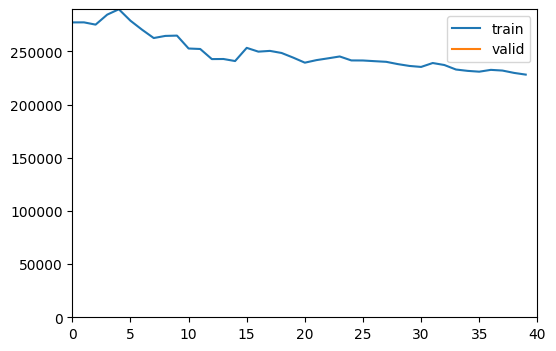

epoch,train_loss,valid_loss,mae,_rmse,mse,time
0,156423.328125,157507.859375,386.301270,396.872589,157507.859375,00:24


Better model found at epoch 0 with valid_loss value: 157507.859375.


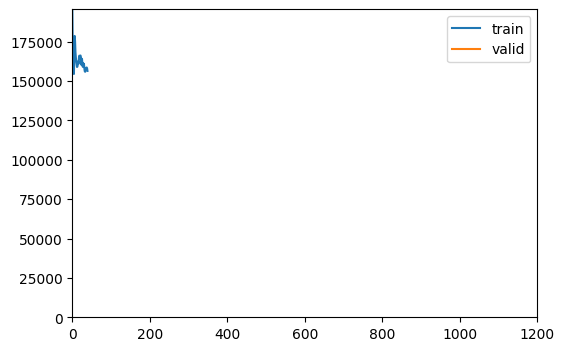

In [ ]:
learn.fine_tune(30,base_lr=1e-3)

In [13]:
dls = db.dataloaders(df,bs=8)

In [14]:
learn.dls=dls

In [15]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.9990639090538025.


(#4) [1.6477665901184082,0.9990639090538025,1.2836536169052124,1.6477665901184082]

In [16]:
from sklearn.metrics import mean_absolute_error

In [17]:
preds,gt = learn.tta()

In [18]:
mean_absolute_error(gt,preds)

0.9949678